In [1]:
%load_ext autotime

!nvidia-smi -L

import os

os.environ['CUDA_VISIBLE_DEVICES']='0'

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-3b49e2b8-87f0-c515-798b-3492ec05a183)
GPU 1: NVIDIA GeForce GTX 1080 Ti (UUID: GPU-07628ed7-6ef8-fd67-7d03-cb6a89f72de4)


In [2]:
import tensorflow as tf , numpy as np, matplotlib.pyplot as plt, glob
from tensorflow import keras
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
from PIL import Image

In [3]:
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
train_img_path = "./data/MoNuSeg 2018 Training Data/Tissue Images/"
train_mask_path = "./data/MoNuSeg 2018 Training Data/Masks/"

test_img_path = "./data/MoNuSegTestData/"
test_mask_path = "./data/MoNuSegTestData/Masks/"

train_img_files = sorted(glob.glob(train_img_path+"*.tif"))
train_mask_files = sorted(glob.glob(train_mask_path+"*.png"))

test_img_files = sorted(glob.glob(test_img_path+"*.tif"))
test_mask_files = sorted(glob.glob(test_mask_path+"*.png"))

In [5]:
# Add (12, 12) pad so Images get (1024, 1024) in size

def img_load(files_path, mask=False):
  res = []
  for img in tqdm(files_path, total=len(files_path)):
    im = Image.open(img)
    im = np.array(im)
    if mask:
      im_padded = np.pad(im, ((12, 12), (12, 12)), constant_values=0)
    else:
      im_padded = np.pad(im, ((12, 12), (12, 12), (0, 0)), constant_values=0)
    res.append(im_padded)
    
  return np.array(res)

In [6]:
train_images = img_load(train_img_files)
train_masks = img_load(train_mask_files, mask=True)
train_masks = np.expand_dims(train_masks, -1)

test_images = img_load(test_img_files)
test_masks = img_load(test_mask_files, mask=True)
test_masks = np.expand_dims(test_masks, -1)

print(train_images.shape, train_masks.shape)
print(test_images.shape, test_masks.shape)

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

(37, 1024, 1024, 3) (37, 1024, 1024, 1)
(14, 1024, 1024, 3) (14, 1024, 1024, 1)


In [7]:
X_train = train_images[:30]
Y_train = train_masks[:30]
X_valid = train_images[30:]
Y_valid = train_masks[30:] 
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

X_train.max(), X_train.min() # so it's just need a rescale

(30, 1024, 1024, 3) (30, 1024, 1024, 1)
(7, 1024, 1024, 3) (7, 1024, 1024, 1)


(255, 0)

In [8]:
def no_overlap_patch(dataset, patch_size=256):
  res = []
  for item in dataset:
    ishape  = item.shape[0]
    for i in range(ishape//patch_size):
      c_p = i*patch_size
      n_p = (i+1)*patch_size
      patch = item[c_p:n_p, c_p:n_p, :]
      res.append(patch)
  
  return np.array(res)

In [9]:
X_train_patched = no_overlap_patch(X_train)
Y_train_patched = no_overlap_patch(Y_train) / 255.
X_valid_patched = no_overlap_patch(X_valid)
Y_valid_patched = no_overlap_patch(Y_valid) / 255.
print(X_train_patched.shape, Y_train_patched.shape)
print(X_valid_patched.shape, Y_valid_patched.shape)

(120, 256, 256, 3) (120, 256, 256, 1)
(28, 256, 256, 3) (28, 256, 256, 1)


(120, 256, 256, 3)


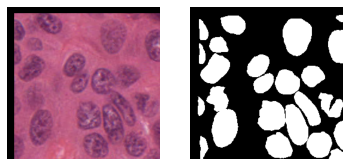

In [10]:
print(np.array(X_train_patched).shape)
im_p = Image.fromarray(X_train_patched[0])
# im_lp = Image.fromarray((Y_train_patched[0]*255).astype(np.uint8))
plt.subplot(1, 2, 1)
plt.imshow(im_p);
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow((Y_train_patched[0]*255).astype(np.uint8), cmap='gray');
plt.axis('off');

In [11]:
keras.backend.clear_session()
filters = 32

inputs = keras.layers.Input(X_train_patched[0].shape)
x = keras.layers.Rescaling(1./255)(inputs)
x = keras.layers.Conv2D(filters*2, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.Conv2D(filters*2, 3, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters*4, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.Conv2D(filters*4, 3, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters*8, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.Conv2D(filters*8, 3, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(filters*8, 3, activation='relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(filters*8, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(filters*4, 3, activation='relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(filters*4, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(filters*2, 3, activation='relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(filters*2, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)

output = keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                             

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_patched, Y_train_patched)).batch(16).shuffle(32).prefetch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_valid_patched, Y_valid_patched)).batch(16).shuffle(32).prefetch(32)

In [13]:
def iou(y_true, y_pred, smooth=1.):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    res = (intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) - intersection + smooth)
    
    return res

In [14]:
model.compile(
  optimizer = 'rmsprop',
  loss='binary_crossentropy',
  metrics = [iou]
)

In [15]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    "./checkpoints/MoNuSeg2018-patched.h5",
    save_best_only=True
  )
]

In [16]:
h = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
8/8 [==============================] - 7s 314ms/step - loss: 0.8009 - iou: 0.1836 - val_loss: 0.6747 - val_iou: 0.2459
Epoch 2/30
8/8 [==============================] - 1s 88ms/step - loss: 0.5964 - iou: 0.2356 - val_loss: 0.6609 - val_iou: 0.2374
Epoch 3/30
8/8 [==============================] - 1s 92ms/step - loss: 0.5306 - iou: 0.2719 - val_loss: 0.6276 - val_iou: 0.2549
Epoch 4/30
8/8 [==============================] - 1s 88ms/step - loss: 0.4518 - iou: 0.3203 - val_loss: 0.6083 - val_iou: 0.2391
Epoch 5/30
8/8 [==============================] - 1s 87ms/step - loss: 0.4007 - iou: 0.3559 - val_loss: 0.6036 - val_iou: 0.2929
Epoch 6/30
8/8 [==============================] - 1s 90ms/step - loss: 0.3800 - iou: 0.3584 - val_loss: 0.5608 - val_iou: 0.2667
Epoch 7/30
8/8 [==============================] - 1s 71ms/step - loss: 0.3618 - iou: 0.3701 - val_loss: 0.6426 - val_iou: 0.1715
Epoch 8/30
8/8 [==============================] - 1s 68ms/step - loss: 0.3336 - iou: 0.3849 - va

1/1 [==============================] - 0s 384ms/step


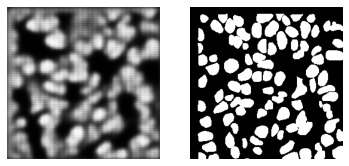

In [17]:
model = keras.models.load_model("./checkpoints/MoNuSeg2018-patched.h5", custom_objects={'iou':iou})

pred = model.predict(np.expand_dims(X_valid_patched[0], 0))

plt.subplot(1, 2, 1)
plt.imshow((pred[0]*255), cmap='gray');
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow((Y_valid_patched[0]*255), cmap='gray');
plt.axis('off');

1/1 [==============================] - 0s 166ms/step


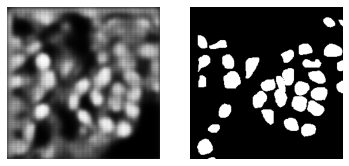

In [18]:
test_images_patched = no_overlap_patch(test_images) 
test_masks_patched = no_overlap_patch(test_masks)

model = keras.models.load_model("./checkpoints/MoNuSeg2018-patched.h5", custom_objects={'iou':iou})

pred = model.predict(np.expand_dims(test_images_patched[0], 0))

plt.subplot(1, 2, 1)
plt.imshow((pred[0]*255), cmap='gray');
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow((test_masks_patched[0]), cmap='gray');
plt.axis('off');